In [1]:
from sklearn.cluster import KMeans
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
import import_ipynb
from load_images_sample import load
from cluster_images_kmeans import cluster
from crop_clustering import cluster_crop
import sys
import skimage
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from tqdm import tqdm_notebook
from sklearn.decomposition import PCA

importing Jupyter notebook from load_images_sample.ipynb
importing Jupyter notebook from cluster_images_kmeans.ipynb
importing Jupyter notebook from crop_clustering.ipynb


In [2]:
def crop(image,k):
    copy = image.copy()
    
    ##perform kmeans clustering with k=4 
    segmented_image,labels = cluster_crop(image,3)
    
    ##create canny edges
    edges = cv.Canny(segmented_image,110,190)

    ##find contours
    contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    ##create bounding rectangle for contours and find rect with max area
    max_area = 0
    m_x = 0
    m_y = 0
    m_w = 0
    m_h = 0
    for cont in contours:
        (x,y,w,h) = cv.boundingRect(cont)
        area = w*h
        if area > max_area:
            max_area = area
            m_x = x
            m_y = y
            m_w = w
            m_h = h
    ##make the rect slightly bigger
    k = 3 ##no of pixels which has to be added to the sides
    
    m_x = max(m_x - k,0)
    m_y = max(m_y - k,0)
    m_h = min(m_h + k,100)
    m_w = min(m_w + k,100)
    ##crop the rectangle!
    
    copy = copy[m_y:m_y+m_h,m_x:m_x+m_w,:]
    if(copy.flatten().size==0):
        return image
    copy = cv.resize(copy,(80,80))
    return copy 

In [3]:
def mask_letter(image,labels):
    back = labels[0] 
    cluster_size = [0,0,0]
    cluster_size[back] = 600000 ##making the cluster size of background very large so that it is never detected as min
    for i in labels:
        cluster_size[i] = cluster_size[i] + 1
    min_ = cluster_size.index(min(cluster_size))

    masked_image = np.copy(image)
    masked_image = masked_image.reshape((-1, 3))
    for i in range(3):
        if i is not min_:
            masked_image[labels == i] = [255, 255, 255]
        else:
            masked_image[labels == i] = [0, 0, 0]
    masked_image = masked_image.reshape(image.shape)
    gray = cv.cvtColor(masked_image,cv.COLOR_RGB2GRAY)
    _, binary_mask = cv.threshold(gray,127,255,cv.THRESH_BINARY)
    return cv.morphologyEx(255-binary_mask,cv.MORPH_OPEN,np.ones((3,3)))

In [4]:
def mask_shape(image,labels):
    back = labels[0]
    cluster_size = [0,0,0]
    for i in labels:
        cluster_size[i] = cluster_size[i] + 1
    cluster_size[back] = -2**16 ##making the cluster size of background zero so that it is never detected as max
    max_ = cluster_size.index(max(cluster_size))
    masked_image = np.copy(image)
    masked_image = masked_image.reshape((-1, 3))
    for i in range(3):
        if i == max_:
            masked_image[labels == i] = [0, 0, 0]
        if i == back:
            masked_image[labels == i] = [255, 255, 255]
        else:
            masked_image[labels == i] = [0, 0, 0]
    masked_image = masked_image.reshape(image.shape)
    gray = cv.cvtColor(masked_image,cv.COLOR_RGB2GRAY)
    _, binary_mask = cv.threshold(gray,127,255,cv.THRESH_BINARY)
    return 255-binary_mask

In [5]:
def pipeline(image):
    
    ## get region of interest
    cropped = crop(image,3)
    
    #Denoising the image
    cropped=cv.fastNlMeansDenoisingColored(cropped,hColor=5,templateWindowSize=3,searchWindowSize=33)
    
    ##perform kmeans clustering on the cropped image with k = 3
    segmented,labels,_ = cluster(cropped,3)
    plt.imshow(segmented)
    plt.show()
    
    ##create binary mask with only letter
    letter = mask_letter(segmented,labels)
    letter = cv.resize(letter,(100,100))
    plt.imshow(letter)
    plt.show()
    
    ##create binary mask with only shape
    shape = mask_shape(segmented,labels)
    shape = cv.resize(shape,(100,100))
    plt.imshow(shape)
    plt.show()
    
    return letter , shape


def pipeline_list(images):
    letters=[]
    shapes=[]
    c=0
    for image in tqdm_notebook(images,desc='segmentation'):
        let,shape=pipeline(image)
        letters.append(let)
        shapes.append(shape)
        c+=1
    return letters,shapes

In [6]:
def main():
    dataset= load()
    pipeline_list(dataset)



<ipython-input-5-8608f2184127>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image in tqdm_notebook(images,desc='segmentation'):


segmentation:   0%|          | 0/33 [00:00<?, ?it/s]

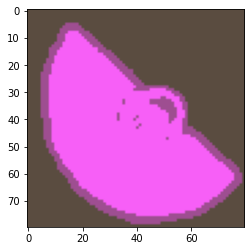

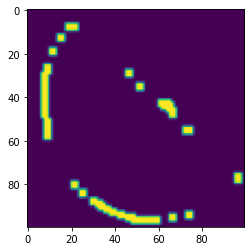

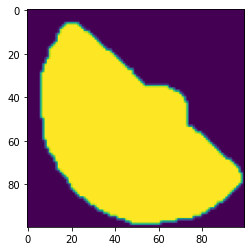

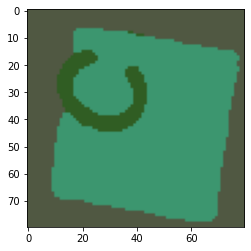

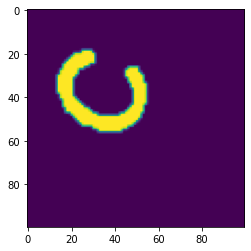

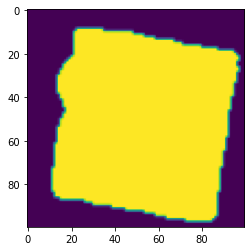

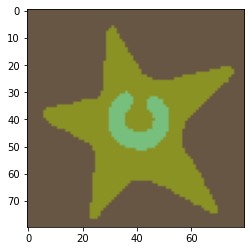

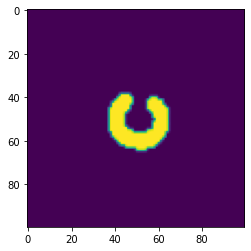

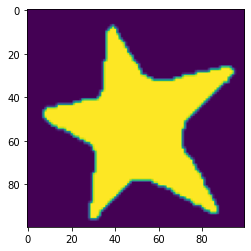

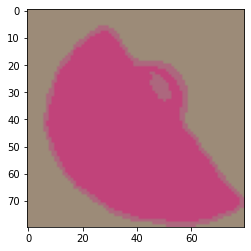

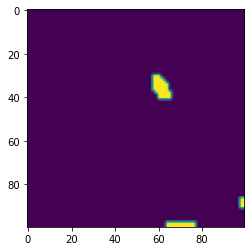

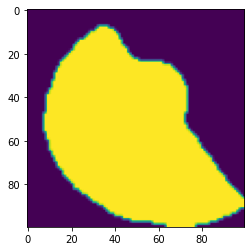

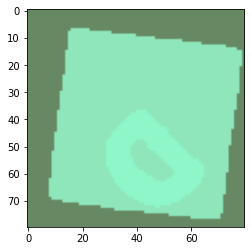

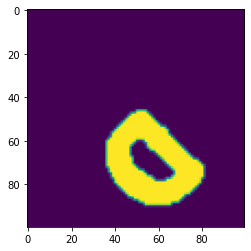

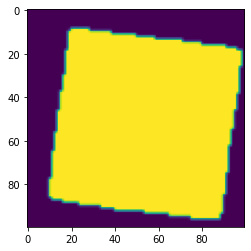

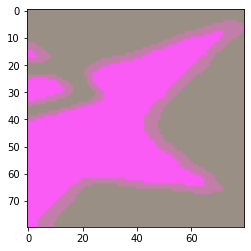

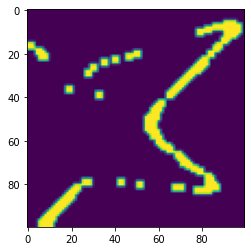

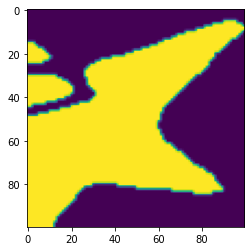

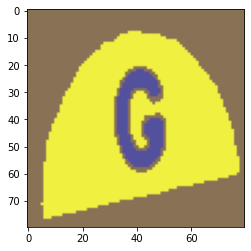

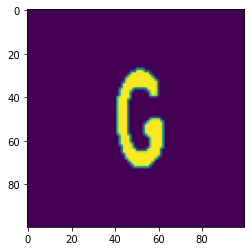

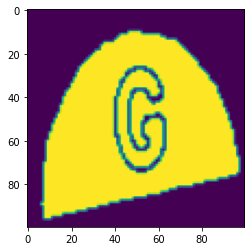

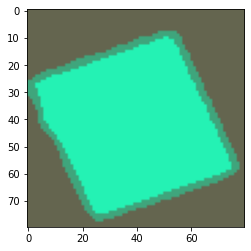

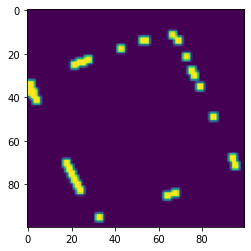

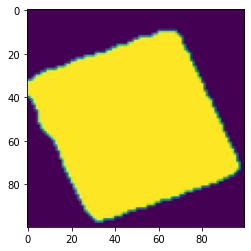

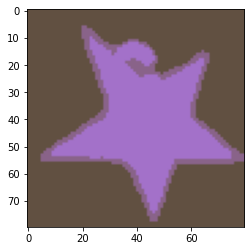

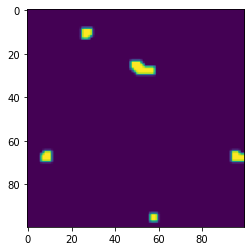

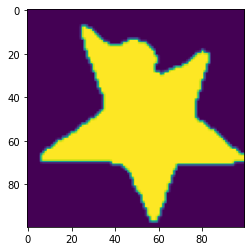

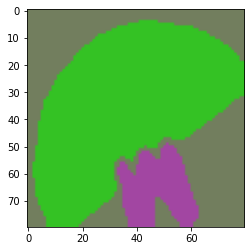

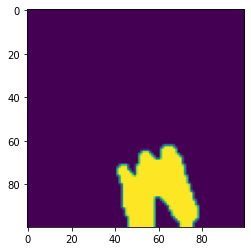

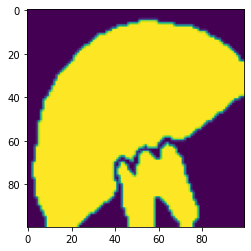

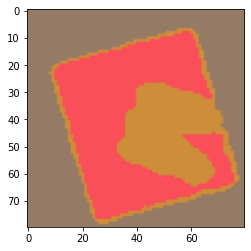

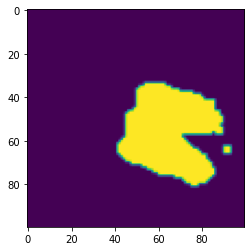

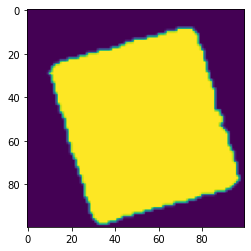

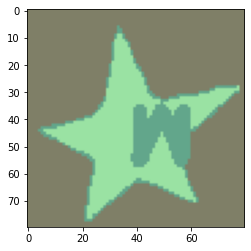

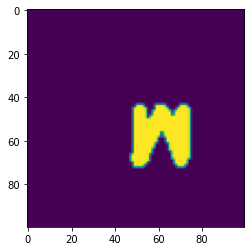

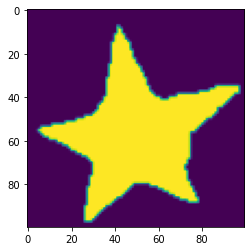

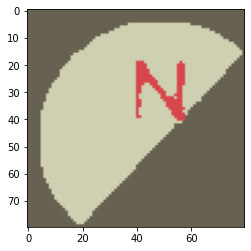

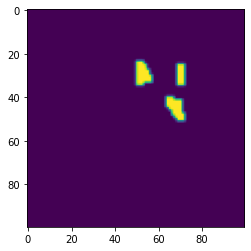

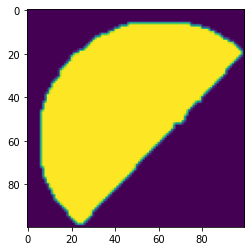

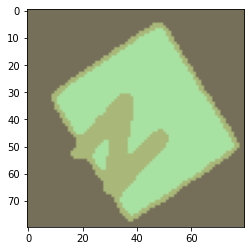

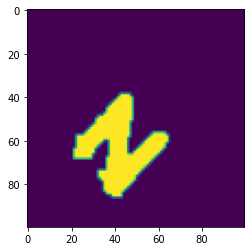

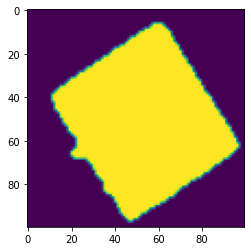

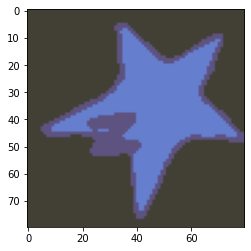

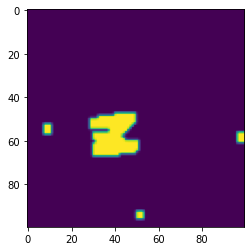

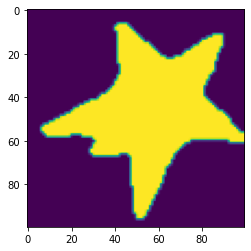

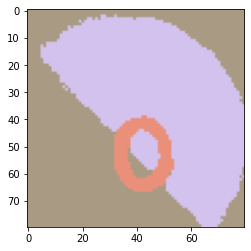

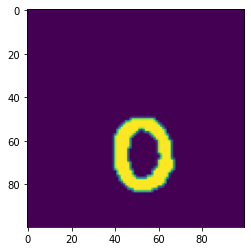

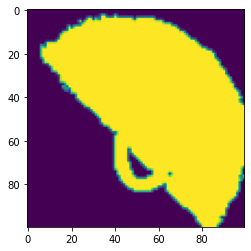

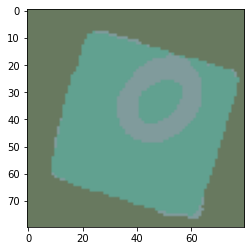

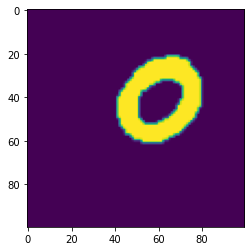

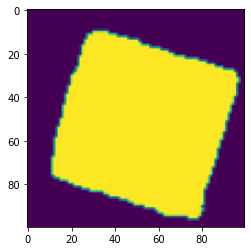

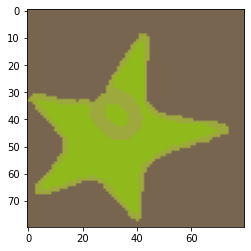

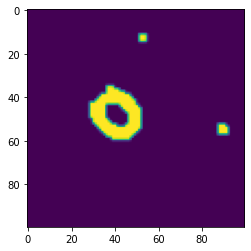

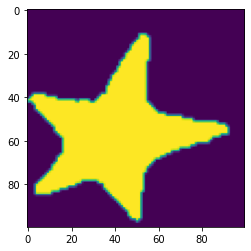

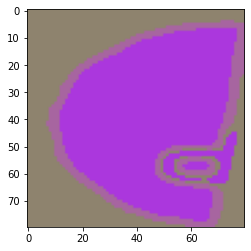

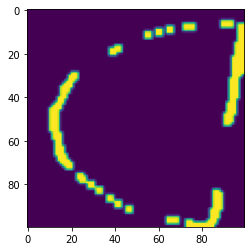

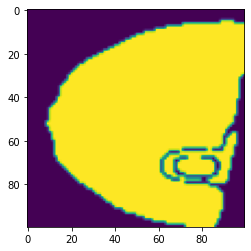

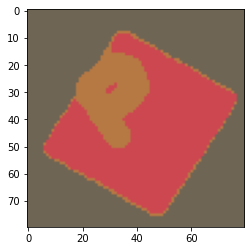

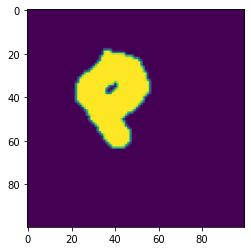

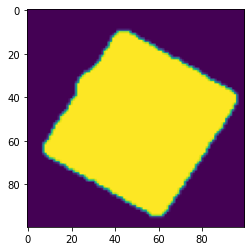

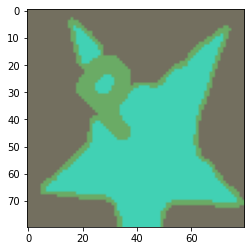

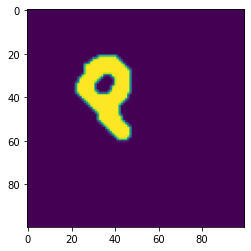

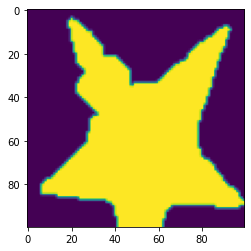

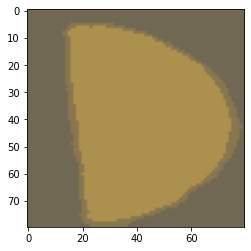

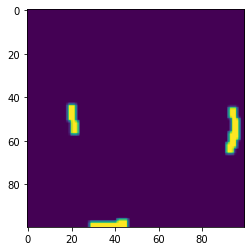

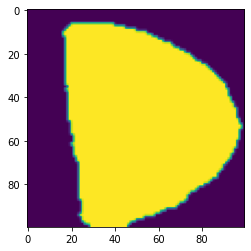

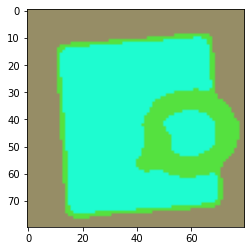

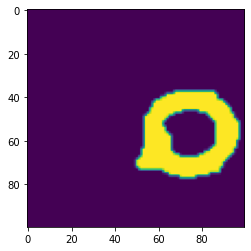

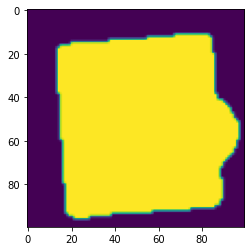

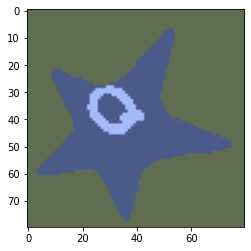

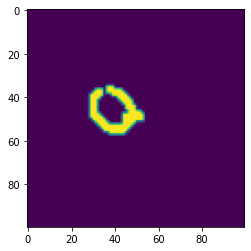

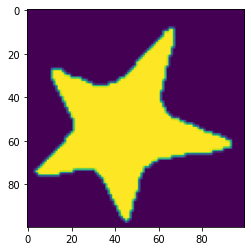

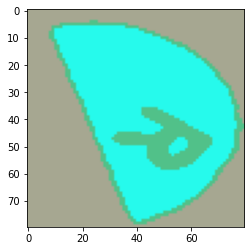

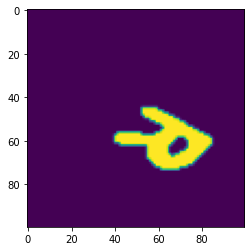

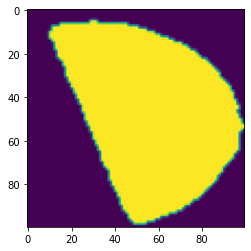

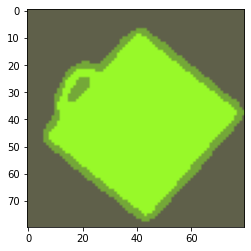

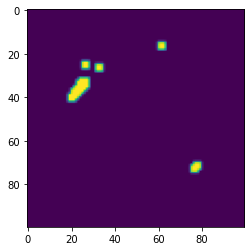

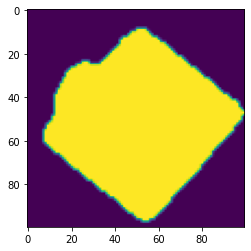

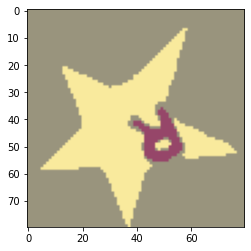

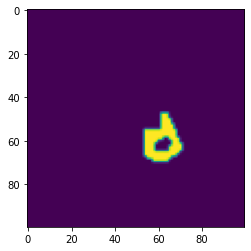

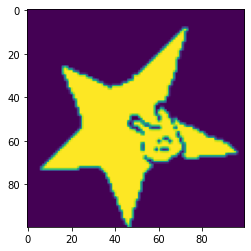

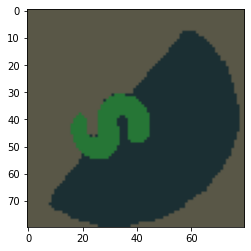

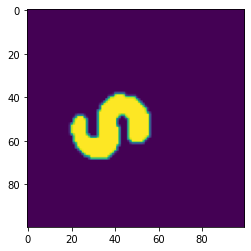

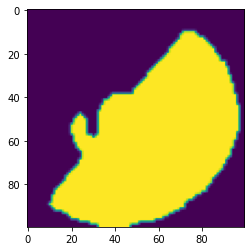

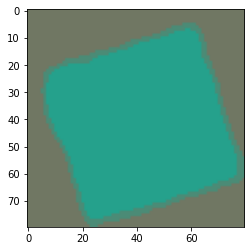

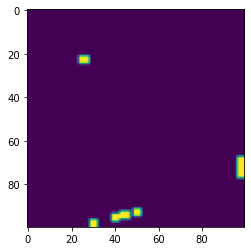

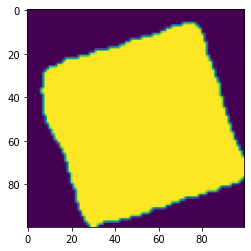

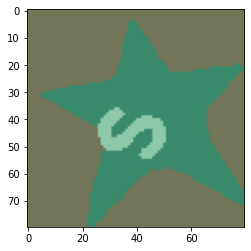

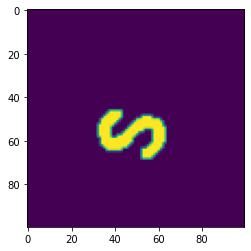

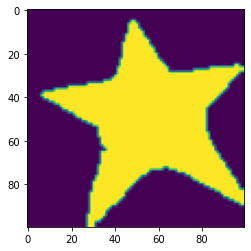

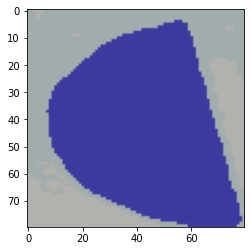

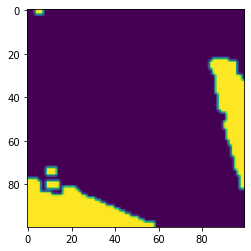

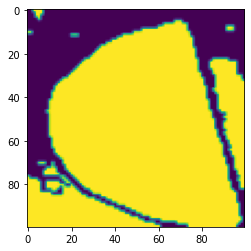

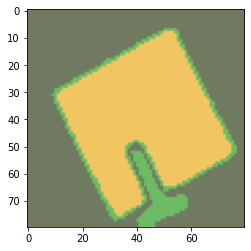

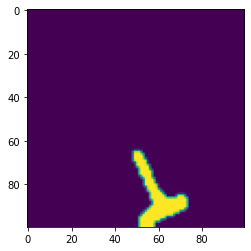

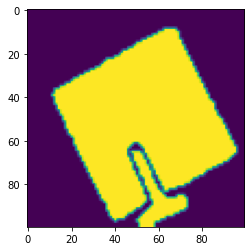

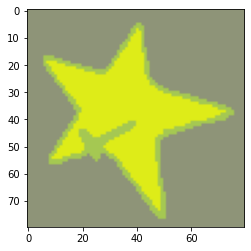

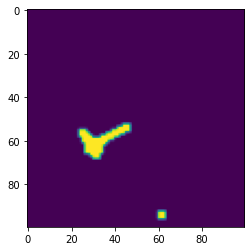

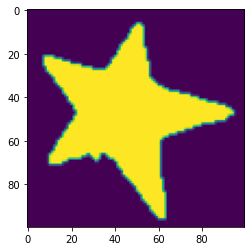

In [7]:
if __name__=="__main__":
        main()